In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

from clim680_utils import latlonticks

# Eastern Pacific Analysis

### This notebook will analyze the effect of sea surface temperatures (SSTs). Specifically, the impact of SSTs in a region off the western coast of North America will be evaluated.

Data sets in use are the soil moisture dataset and SST dataset, both described in other notebooks.

In [2]:
sw = xr.open_dataset("/scratch/dklein3/soilw.mon.mean.v2.nc")
sst = xr.open_dataset("/scratch/dklein3/clim680/sst.mon.mean.nc")
sst

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1570)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1891-01-01 1891-02-01 ... 2021-10-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    title:            COBE Sea Surface Temperature Analysis
    history:          created June 2011 at ESRL/PSD using the grib data from ...
    platform:         Analyses
    original_source:  http://near-goos1.jodc.go.jp/cgi-bin/1997/near_goos_cat...
    Conventions:      CF-1.2
    institution:      NOAA ESRL/PSD
    comment:          recent values (w/i last year) may change as dataset is ...
    dataset_title:    COBE Sea Surface Temperature
    References:       https://www.psl.noaa.gov/data/gridded/data.cobe.html

Reversing the latitudes of the SST database and shrinking the time frame to match the soil moisture data.

In [3]:
sst=sst.sel(time=slice(sw['time'][0],sw['time'][-1]))
sst=sst.reindex(lat=list(reversed(sst['lat'])))
sst

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 884)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-08-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    title:            COBE Sea Surface Temperature Analysis
    history:          created June 2011 at ESRL/PSD using the grib data from ...
    platform:         Analyses
    original_source:  http://near-goos1.jodc.go.jp/cgi-bin/1997/near_goos_cat...
    Conventions:      CF-1.2
    institution:      NOAA ESRL/PSD
    comment:          recent values (w/i last year) may change as dataset is ...
    dataset_title:    COBE Sea Surface Temperature
    References:       https://www.psl.noaa.gov/data/gridded/data.cobe.html

#### Creating the East Pacific SST index. The index will be the mean monthly SST of the area between 27-48N and 125-158W. Monthly anomaly values will be used to evaluate the impact on soil moisture.

In [4]:
eastpac=sst.sel(lon=slice(360-158,360-125),lat=slice(27,48))
eastpac

<xarray.Dataset>
Dimensions:  (lat: 21, lon: 33, time: 884)
Coordinates:
  * lat      (lat) float32 27.5 28.5 29.5 30.5 31.5 ... 43.5 44.5 45.5 46.5 47.5
  * lon      (lon) float32 202.5 203.5 204.5 205.5 ... 231.5 232.5 233.5 234.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-08-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    title:            COBE Sea Surface Temperature Analysis
    history:          created June 2011 at ESRL/PSD using the grib data from ...
    platform:         Analyses
    original_source:  http://near-goos1.jodc.go.jp/cgi-bin/1997/near_goos_cat...
    Conventions:      CF-1.2
    institution:      NOAA ESRL/PSD
    comment:          recent values (w/i last year) may change as dataset is ...
    dataset_title:    COBE Sea Surface Temperature
    References:       https://www.psl.noaa.gov/data/gridded/data.cobe.html

In [5]:
eastpacindex=eastpac.mean(dim=['lat','lon'])
eastpacindex

<xarray.Dataset>
Dimensions:  (time: 884)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-08-01
Data variables:
    sst      (time) float32 14.37 13.84 13.51 13.28 ... 15.49 17.27 19.22 20.91

In [6]:
eastpacclimo=eastpacindex.groupby('time.month').mean()
eastpacanom=eastpacindex.groupby('time.month') - eastpacclimo
eastpacanom=eastpacanom.drop_vars('month')
eastpacanom

<xarray.Dataset>
Dimensions:  (time: 884)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-08-01
Data variables:
    sst      (time) float32 0.2061 0.2698 0.1784 -0.302 ... 0.94 0.9106 0.9955

#### Establishing time periods of positive and negative 'East Pacific Index' anomalies.

In [7]:
eastpacanom
pos_epa=eastpacanom['sst'].where(eastpacanom['sst']>=0)
neg_epa=eastpacanom['sst'].where(eastpacanom['sst']<0)
pos_epa

<xarray.DataArray 'sst' (time: 884)>
array([2.06147194e-01, 2.69813538e-01, 1.78371429e-01,            nan,
       2.34939575e-01, 3.62892151e-01,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan, 2.88554192e-01, 2.70519257e-01, 3.53278160e-01,
       3.39715004e-01, 1.70721054e-01,            nan,            nan,
       3.16635132e-01, 2.22301483e-01, 2.95284271e-01, 1.67416573e-01,
       8.01916122e-02, 1.27994537e-01, 2.32161522e-01, 9.21278000e-02,
       1.51355743e-01, 9.64832306e-02, 1.70976639e-01, 5.81283569e-02,
       9.28249359e-02,            nan,            nan,            nan,
                  nan,            nan,            nan, 3.82699966e-02,
       1.91017151e-01, 1.73761368e-01, 3.21306229e-01, 4.33303833e-01,
       2.22105026e-01, 4.10087585e-01, 3.70355606e-01, 1.58128738e-02,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
...
       9.95215416e-01, 1.18798065e+00, 1.49503708e+00, 1.44746971e+00,
       9.78895187e-01, 8.55022430e-01, 9.74802017e-01, 7.20340729e-01,
       4.07141685e-01, 3.57548714e-01, 1.65337563e-01, 3.69807243e-01,
       5.30105591e-01, 3.59020233e-01, 3.61984253e-01, 2.94792175e-01,
       7.24525452e-01, 3.78189087e-01,            nan,            nan,
                  nan,            nan, 2.82001495e-03, 3.11746597e-02,
       7.44924545e-02, 4.12693024e-02, 1.95072174e-01, 4.85225677e-01,
       3.99347305e-01, 1.33251190e-01, 1.98982239e-01,            nan,
       7.07063675e-02, 1.70804024e-01, 9.61370468e-02, 1.02294922e-01,
       1.55590057e-01, 2.34418869e-01, 1.69546127e-01,            nan,
                  nan, 4.90484238e-01, 9.08960342e-01, 4.74143982e-01,
       2.83861160e-01, 3.39679718e-02,            nan, 2.04235077e-01,
       2.80949593e-01, 7.58470535e-01, 1.29068565e+00, 1.67901611e+00,
       1.49249077e+00, 1.24585915e+00, 1.45296669e+00, 7.72064209e-01,
       4.46065903e-01, 4.48262215e-01, 4.24938202e-01, 8.88779640e-01,
       1.01393795e+00, 1.01774216e+00, 1.23114967e+00, 1.16207314e+00,
       1.43384743e+00, 1.39691734e+00, 1.51046181e+00, 1.13472748e+00,
       7.55848885e-01, 6.98459625e-01, 3.91527176e-01, 4.62100983e-01,
       8.88285637e-01, 9.40025330e-01, 9.10625458e-01, 9.95452881e-01],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-08-01

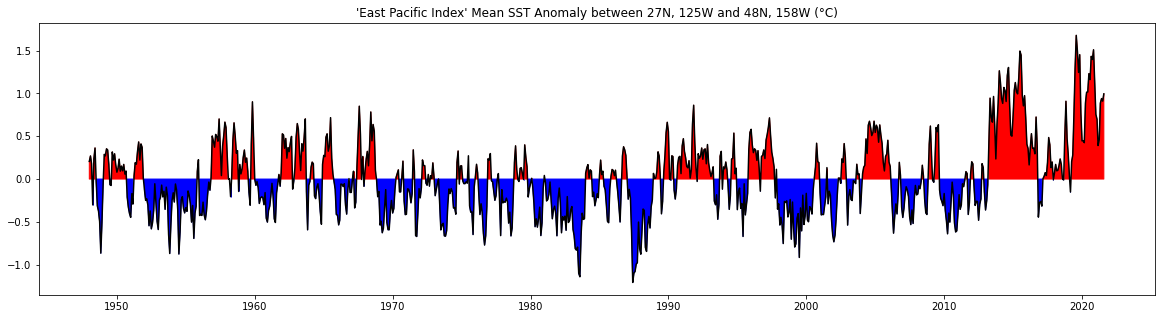

In [8]:
plt.figure(figsize=(20,5))
plt.plot(eastpacanom['time'],eastpacanom['sst'],'k')
plt.fill_between(eastpacanom['time'],0,pos_epa,color='red')
plt.fill_between(eastpacanom['time'],0,neg_epa,color='blue')
plt.title("'East Pacific Index' Mean SST Anomaly between 27N, 125W and 48N, 158W (°C)")
plt.savefig('eastpacindex.png')

#### Creating composite maps.

In [9]:
sw_climo=sw.groupby('time.month').mean()
sw_anom=sw.groupby('time.month')-sw_climo
sw_anom

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 884)
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-08-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 10 11 12 1 2 3 4 5 6 7 8
Data variables:
    soilw    (time, lat, lon) float32 nan nan nan nan ... 145.5 145.5 145.5

In [10]:
pos_epa_sw=sw_anom.sel(time=pos_epa.dropna(dim='time')['time']).mean(dim='time')
neg_epa_sw=sw_anom.sel(time=neg_epa.dropna(dim='time')['time']).mean(dim='time')
comp_sw=[pos_epa_sw,neg_epa_sw]
comp_sw

[<xarray.Dataset>
 Dimensions:  (lat: 360, lon: 720)
 Coordinates:
   * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
   * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
 Data variables:
     soilw    (lat, lon) float32 nan nan nan nan nan ... 12.04 12.05 12.06 12.06,
 <xarray.Dataset>
 Dimensions:  (lat: 360, lon: 720)
 Coordinates:
   * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
   * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
 Data variables:
     soilw    (lat, lon) float32 nan nan nan nan ... -10.07 -10.08 -10.09 -10.09]

#### Plotting the composites.

Text(0.5, 0.98, 'Composite Soil Moisture Anomalies with Eastern Pacific Index')

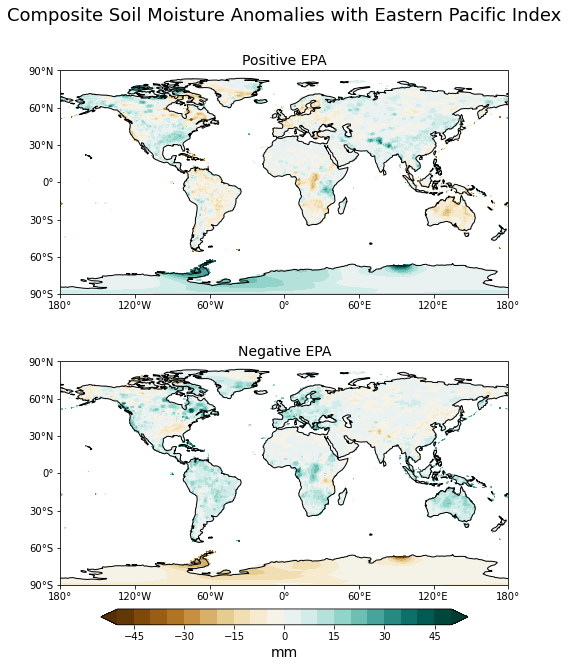

In [13]:
labels=['Positive EPA','Negative EPA']
clevs=np.arange(-50,55,5)

# Define the figure and each axis for the 2 rows and 1 column
fig, axs = plt.subplots(nrows=2,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,11))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over the positive and negative EPA and plot
for i,index in enumerate(comp_sw):

        # Select the condition
        data=comp_sw[i]['soilw']

        # Add the cyclic point
        data,lons=add_cyclic_point(data,coord=comp_sw[i]['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,comp_sw[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot
        axs[i].set_title(labels[i],fontsize=14)

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95, wspace=0.1, hspace=0.3)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='mm')
cbar.set_label(label='mm',size=14)

# Add a big title at the top
plt.suptitle('Composite Soil Moisture Anomalies with Eastern Pacific Index', fontsize=18)

#### Determining and plotting the statistical significance of the composites.

In [15]:
from scipy.stats import ttest_ind
diff_sw=pos_epa_sw-neg_epa_sw
p=0.05

pos_epa_sw_vals=sw_anom.sel(time=pos_epa.dropna(dim='time')['time'])
neg_epa_sw_vals=sw_anom.sel(time=neg_epa.dropna(dim='time')['time'])

tstat,pval=ttest_ind(pos_epa_sw_vals['soilw'], 
                neg_epa_sw_vals['soilw'], 
                equal_var = False)
mask_diff=diff_sw['soilw'].where(pval<p)

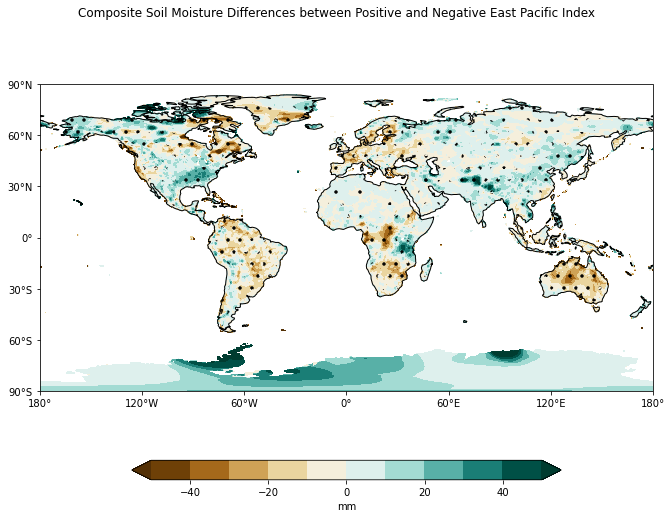

In [17]:
clevs=np.arange(-50,60,10)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
axs=plt.axes(projection=ccrs.PlateCarree())

data=diff_sw['soilw']

# Add the cyclic point
data,lons=add_cyclic_point(data,coord=diff_sw['lon'])
mask_data,lons=add_cyclic_point(mask_diff,coord=diff_sw['lon'])

# Contour plot
cs=axs.contourf(lons,diff_sw['lat'],data,clevs,
                    transform = ccrs.PlateCarree(),
                    cmap='BrBG',extend='both')

axs.contourf(lons,diff_sw['lat'],mask_data,[0,1],
              transform = ccrs.PlateCarree(),colors='None',
             hatches=['.',''],extend='both',alpha=0)

# Draw the coastines for each subplot
axs.coastlines()

# Put in latitude and longitutde ticks
latlonticks(axs)

# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='mm')
        
# Add a big title at the top
plt.suptitle('Composite Soil Moisture Differences between Positive and Negative East Pacific Index')
plt.savefig('EPAcomp.png')

#### Determining the correlation and linear regression between the 'East Pacific Index' and soil moisture.

In [18]:
from scipy.stats import linregress
lon=(len(sw_anom['lon']))
lat=(len(sw_anom['lat']))
m_array=np.zeros((lat,lon))
p_array=np.zeros((lat,lon))
r_array=np.zeros((lat,lon))
for i in range(lon):
    for j in range(lat):
        m_array[j,i], intercept, r_array[j,i], p_array[j,i], std_err = linregress(eastpacanom['sst'], sw_anom['soilw'][:,j,i])
r_array

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

Adjusting the significance for the number of data points

In [19]:
def fdr(p_vals):

    # from https://stackoverflow.com/questions/25185205/calculating-adjusted-p-values-in-python  
    from scipy.stats import rankdata
    ranked_p_values = rankdata(p_vals)
    fdr = p_vals * len(p_vals) / ranked_p_values
    fdr[fdr > 1] = 1

    return fdr

In [20]:
# function expecting vector so reshape 2D p value array as vector
p_array_vec=np.ravel(p_array, order='C')
p_array_corrected_vec=fdr(p_array_vec)
# reshape corrected p value vectore back to 2D array
p_array_corrected=np.reshape(p_array_corrected_vec, (360,720), order='C')
mask_sig2=np.where(p_array_corrected<0.05,r_array,np.nan)

#### Plotting the correlation between the 'East Pacific Index' and soil moisture.

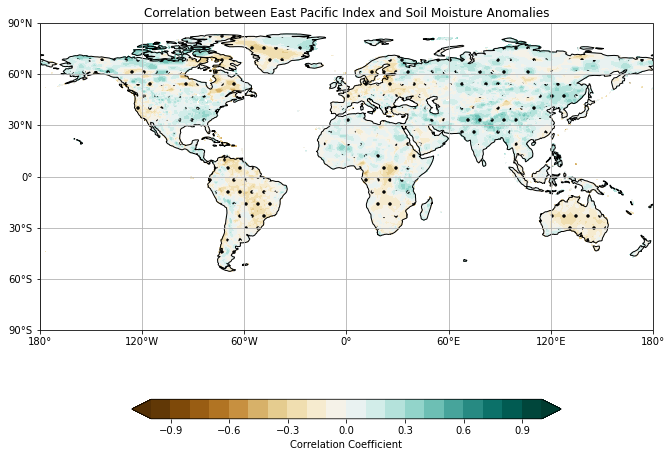

In [22]:
clevs=np.arange(-1,1.1,0.1)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree())

# Add cyclic point
data=r_array
data,lon=add_cyclic_point(data,coord=sw_anom['lon'])
mask_data,lons=add_cyclic_point(mask_sig2,coord=sw_anom['lon'])

# Make a filled contour plot
cs=ax.contourf(lon,sw_anom['lat'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='BrBG',extend='both')

ax.contourf(lon,sw_anom['lat'],mask_data,[0,1],
            transform = ccrs.PlateCarree(),colors='None',
            hatches=['.','.'],extend='both',alpha=0)

# Add coastlines
ax.coastlines()

# Add gridlines
ax.gridlines()

# Put in latitude and longitutde ticks
latlonticks(ax)

# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Correlation Coefficient')

# Add title
plt.title('Correlation between East Pacific Index and Soil Moisture Anomalies')
plt.savefig('EPAcorr.png')

#### Plotting the linear regression between 'East Pacific Index' and soil moisture.

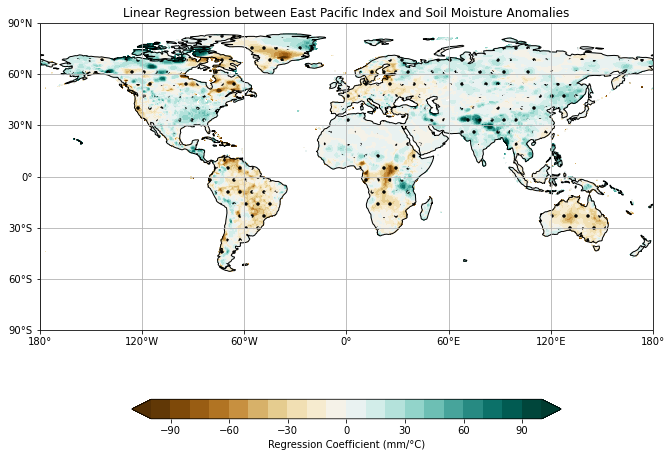

In [23]:
clevs=np.arange(-100,110,10)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree())

# Add cyclic point
data=m_array
data,lon=add_cyclic_point(data,coord=sw_anom['lon'])
mask_data,lons=add_cyclic_point(mask_sig2,coord=sw_anom['lon'])

# Make a filled contour plot
cs=ax.contourf(lon,sw_anom['lat'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='BrBG',extend='both')

ax.contourf(lon,sw_anom['lat'],mask_data,[0,1],
            transform = ccrs.PlateCarree(),colors='None',
            hatches=['.','.'],extend='both',alpha=0)

# Add coastlines
ax.coastlines()

# Add gridlines
ax.gridlines()

# Put in latitude and longitutde ticks
latlonticks(ax)

# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Regression Coefficient (mm/°C)')

# Add title
plt.title('Linear Regression between East Pacific Index and Soil Moisture Anomalies')
plt.savefig('EPAlinreg.png')